# BERT (Updated 1 Feb 2025, Available CUDA)

We shall implement BERT.  For this tutorial, you may want to first look at my Transformers tutorial to get a basic understanding of Transformers. 

For BERT, the main difference is on how we process the datasets, i.e., masking.   Aside from that, the backbone model is still the Transformers.

In [1]:
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
device
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# torch.cuda.get_device_name(0)

cuda


## 1. Data

For simplicity, we shall use very simple data like this.

In [8]:
from datasets import load_dataset

# Load BookCorpus dataset
# The first 1% of `train` split.
dataset = load_dataset('bookcorpus', split='train[:1%]')
dataset

Dataset({
    features: ['text'],
    num_rows: 740042
})

In [6]:
sentences = dataset['text']
text = [x.lower() for x in sentences] #lower case
text = [re.sub("[.,!?\\-]", '', x) for x in text] #clean all symbols
# text
len(text)

740042

In [5]:
for sentence in text:
    print(sentence, "_____")
    words = sentence.split()
    print(words)
    break

usually  he would be tearing around the living room  playing with his toys  _____
['usually', 'he', 'would', 'be', 'tearing', 'around', 'the', 'living', 'room', 'playing', 'with', 'his', 'toys']


### Making vocabs

Before making the vocabs, let's remove all question marks and perios, etc, then turn everything to lowercase, and then simply split the text. 

In [6]:
from tqdm.auto import tqdm

# Combine everything into one to make vocab
word_list = list(set(" ".join(text).split()))
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}  # special tokens

# Create the word2id in a single pass
for i, w in tqdm(enumerate(word_list), desc="Creating word2id"):
    word2id[w] = i + 4  # because 0-3 are already occupied

# Precompute the id2word mapping (this can be done once after word2id is fully populated)
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id)
vocab_size

Creating word2id: 0it [00:00, ?it/s]

60305

In [7]:
vocab_size = len(word2id)

# List of all tokens for the whole text
token_list = []

# Process sentences more efficiently
for sentence in tqdm(text, desc="Processing sentences"):
    token_list.append([word2id[word] for word in sentence.split()])

# Now token_list contains the tokenized sentences

Processing sentences:   0%|          | 0/740042 [00:00<?, ?it/s]

In [8]:
#take a look at sentences
sentences[:2]

['usually , he would be tearing around the living room , playing with his toys .',
 'but just one look at a minion sent him practically catatonic .']

In [9]:
#take a look at token_list
token_list[:2]

[[4054,
  46434,
  51788,
  39453,
  4615,
  13275,
  49296,
  11679,
  13978,
  14681,
  42817,
  20055,
  53304],
 [27558, 33884, 50528, 56699, 58265, 46612, 2997, 1657, 425, 4552, 21984]]

In [10]:
#testing one sentence
for tokens in token_list[0]:
    print(id2word[tokens])

usually
he
would
be
tearing
around
the
living
room
playing
with
his
toys


## 2. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”. 

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred` 

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`. 

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [11]:
batch_size = 16
max_mask   = 5  # max masked tokens when 15% exceed, it will only be max_pred
max_len    = 1000 # maximum of length to be padded; 

In [12]:
def make_batch():
    batch = []
    positive = negative = 0  #count of batch size;  we want to have half batch that are positive pairs (i.e., next sentence pairs)
    while positive != batch_size/2 or negative != batch_size/2:
        
        #randomly choose two sentence so we can put [SEP]
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences))
        #retrieve the two sentences
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - append CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3. mask language modeling
        #masked 15%, but should be at least 1 but does not exceed max_mask
        n_pred =  min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get the pos that excludes CLS and SEP and shuffle them
        cand_maked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]'] and token != word2id['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and change the input_ids to [MASK]
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)  #remember the position
            masked_tokens.append(input_ids[pos]) #remember the tokens
            #80% replace with a [MASK], but 10% will replace with a random token
            if random() < 0.1:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word2id[id2word[index]] # replace
            elif random() < 0.9:  # 80%
                input_ids[pos] = word2id['[MASK]'] # make mask
            else:  #10% do nothing
                pass

        # pad the input_ids and segment ids until the max len
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # pad the masked_tokens and masked_pos to make sure the lenth is max_mask
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #check if first sentence is really comes before the second sentence
        #also make sure positive is exactly half the batch size
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
            
    return batch

In [13]:
# batch = make_batch()

In [14]:
#len of batch
# len(batch)

In [15]:
# #we can deconstruct using map and zip
# input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
# input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext.shape

## 3. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 3.1 Embedding

Here we simply generate the positional embedding, and sum the token embedding, positional embedding, and segment embedding together.

<img src = "figures/BERT_embed.png" width=500>

In [16]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 3.2 Attention mask

In [19]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [20]:
# print(get_attn_pad_mask(input_ids, input_ids, device).shape)

## 3.3 Encoder

The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [22]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

Let's define the parameters first

In [23]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

Here is the Multiheadattention.

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

Here is the PoswiseFeedForwardNet.

In [25]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

## 3.4 Putting them together

In [26]:
class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        
        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

## 4. Training

In [27]:
from tqdm.auto import tqdm

n_layers = 12    # number of Encoder of Encoder Layer
n_heads  = 12    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = d_model * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

num_epoch = 1000
model = BERT(
    n_layers, 
    n_heads, 
    d_model, 
    d_ff, 
    d_k, 
    n_segments, 
    vocab_size, 
    max_len, 
    device
)  # Move model to GPU

if num_gpus > 1:
    model = nn.DataParallel(model)  # Enable multi-GPU training
model.to(device)

DataParallel(
  (module): BERT(
    (embedding): Embedding(
      (tok_embed): Embedding(60305, 768)
      (pos_embed): Embedding(1000, 768)
      (seg_embed): Embedding(2, 768)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (layers): ModuleList(
      (0-11): 12 x EncoderLayer(
        (enc_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=768, out_features=768, bias=True)
          (W_K): Linear(in_features=768, out_features=768, bias=True)
          (W_V): Linear(in_features=768, out_features=768, bias=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (activ): Tanh()
    (linear): Linear(in_features=768, out_features=768, bias=True)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

# Move inputs to GPU
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

loss_history = []

# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_epoch), desc="Training Epochs"):
    optimizer.zero_grad()
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
    #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
    #logits_nsp: (bs, yes/no) ==> (6, 2)

    #1. mlm loss
    #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    #2. nsp loss
    #logits_nsp: (bs, 2) vs. isNext: (bs, )
    loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
    
    #3. combine loss
    loss = loss_lm + loss_nsp
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print('Epoch:', '%02d' % (epoch), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 00 loss = 121.058174
Epoch: 100 loss = 5.013710
Epoch: 200 loss = 4.354011
Epoch: 300 loss = 4.301591
Epoch: 400 loss = 4.368188
Epoch: 500 loss = 4.633116
Epoch: 600 loss = 4.229721
Epoch: 700 loss = 4.446434
Epoch: 800 loss = 4.206721
Epoch: 900 loss = 4.194649


In [32]:
import matplotlib.pyplot as plt

def plot_data(loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    # plt.plot(v?al_acc_history, label = 'Validation')
    # plt.title('Accuracy per epoch')
    # plt.legend()
    # plt.show()
    plt.savefig('train_loss.png')

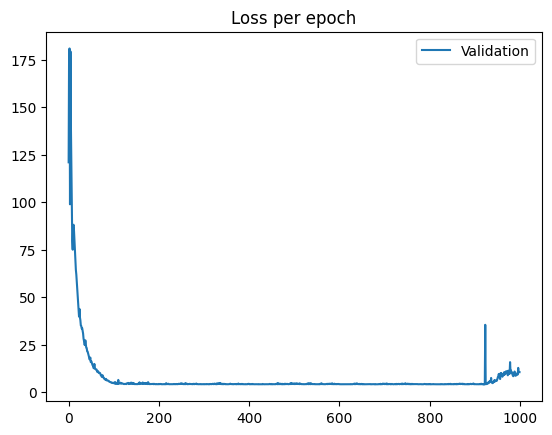

<Figure size 640x480 with 0 Axes>

In [33]:
plot_data(loss_history)

In [34]:
# Save the model after training
torch.save(model.state_dict(), 'bert_model.pth')
print("Model saved to bert_model.pth")

Model saved to bert_model.pth


## 5. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

In [35]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[2]))
print([id2word[w.item()] for w in input_ids[0] if id2word[w.item()] != '[PAD]'])
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy() 
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[id2word[pos.item()] for pos in masked_tokens[0]])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0]])
print('masked tokens (words) : ',[id2word[pos.item()] for pos in logits_lm])
print('predict masked tokens list : ', [pos for pos in logits_lm])

#predict nsp
logits_nsp = logits_nsp.cpu().data.max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_nsp else False)

['[CLS]', 'as', 'he', 'rounded', 'the', 'corner', 'and', 'strolled', 'toward', 'todayfor', 'culdesac', 'where', '[MASK]', "'s", 'house', '[MASK]', 'nestled', 'he', 'realized', 'that', 'she', 'was', '[MASK]', 'at', 'the', 'bottom', 'of', '[MASK]', 'gravel', 'driveway', 'and', 'she', 'was', 'not', 'alone', '[SEP]', '``', 'can', 'i', 'ask', 'you', 'something', "''", '[SEP]']
masked tokens (words) :  ['standing', 'celine', 'the', 'the', 'was']
masked tokens list :  [47858, 55370, 49296, 49296, 55286]
masked tokens (words) :  ['mouthed', 'mouthed', 'mouthed', 'mouthed', 'mouthed']
predict masked tokens list :  [33894, 33894, 33894, 33894, 33894]
0
isNext :  False
predict isNext :  False


Trying a bigger dataset should be able to see the difference.